In [8]:
import LibsControl
import numpy
import matplotlib.pyplot as plt

import servo_identification

#load dynamics from log file
def load_from_file(file_name, dt):
    v = numpy.loadtxt(file_name)

    u = numpy.array(v[:, 1:3])
    x = numpy.array(v[:, 3:5])


    t = numpy.arange(x.shape[0])*dt

    return u, x, t

def difference(x):
    #add velocity terms
    x_pad = numpy.zeros((1, x.shape[1]))
    x_tmp = numpy.concatenate([x_pad, x], axis=0)

    #estimate velocity term
    dx = x_tmp[1:, :]  - x_tmp[0:-1, :]

    return dx

def state_augmentation(x):   
    #zero initial conditions
    x_aug = x - x[0]

    x_aug = x_aug - numpy.mean(x_aug, axis=0)

    vel = difference(x_aug[:, 0:2])
    x_aug = numpy.concatenate([x_aug, vel], axis=1)

    return x_aug



def plot_results(t_result, u_result, x_ref, x_pred, steps_start = 0 , steps_end = -1, dt = 1.0/250.0):

    plt.clf()

    axis_count = 4
    if x_ref.shape[1] == 4:
        axis_count+= 2

    fig, axs = plt.subplots(axis_count, 1, figsize=(8, 2*5))


    u_result*= 60.0/(2.0*numpy.pi)


    axs[0].plot(t_result[steps_start:steps_end], u_result[steps_start:steps_end, 0], color="purple")
    axs[0].set_xlabel("time [s]")
    axs[0].set_ylabel("control forward")
    axs[0].grid()

    axs[1].plot(t_result[steps_start:steps_end], u_result[steps_start:steps_end, 1], color="purple")
    axs[1].set_xlabel("time [s]")
    axs[1].set_ylabel("control turn")
    axs[1].grid()


    axs[2].plot(t_result[steps_start:steps_end], x_ref[steps_start:steps_end, 0], label="ground truth", color="red")
    axs[2].plot(t_result[steps_start:steps_end], x_pred[steps_start:steps_end, 0], label="prediction", color="blue")
    axs[2].set_xlabel("time [s]")
    axs[2].set_ylabel("distance [mm]")
    axs[2].legend()
    axs[2].grid()

    axs[3].plot(t_result[steps_start:steps_end], x_ref[steps_start:steps_end, 1]*180.0/numpy.pi, color="red")
    axs[3].plot(t_result[steps_start:steps_end], x_pred[steps_start:steps_end, 1]*180.0/numpy.pi, color="blue")
    axs[3].set_xlabel("time [s]")
    axs[3].set_ylabel("angle [deg]")
    axs[3].grid()


    if axis_count == 6:
        axs[4].plot(t_result[steps_start:steps_end], x_ref[steps_start:steps_end, 2]/dt, label="ground truth", color="red")
        axs[4].plot(t_result[steps_start:steps_end], x_pred[steps_start:steps_end, 2]/dt, label="prediction", color="blue")
        axs[4].set_xlabel("time [s]")
        axs[4].set_ylabel("velocity [mm/s]")
        axs[4].legend()
        axs[4].grid()

        axs[5].plot(t_result[steps_start:steps_end], x_ref[steps_start:steps_end, 3]*(180.0/numpy.pi)/dt, color="red")
        axs[5].plot(t_result[steps_start:steps_end], x_pred[steps_start:steps_end, 3]*(180.0/numpy.pi)/dt, color="blue")
        axs[5].set_xlabel("time [s]")
        axs[5].set_ylabel("angular velocity [deg/s]")
        axs[5].grid()
        
    

    #fig.legend()


def matrix_to_c(name, x, eps = 10**-10, const_array = False):

    x_tmp = x.copy()

    x_tmp[numpy.where(numpy.abs(x_tmp) < eps)] = 0.0

    result_str = "" 

    if const_array:
        result_str+= "const "
        
    result_str+= "float " + name + "[] = {\n"
    for m in range(x.shape[0]):
        result_str+= "\t\t"
        for n in range(x.shape[1]):
            result_str+= str(numpy.float32(x_tmp[m][n]))
            if m == x.shape[0]-1 and n == x.shape[1]-1:
                result_str+= " "
            else:
                result_str+= ", "
       
        if m != x.shape[0]-1:
            result_str+= "\n"

    result_str+= "};\n"

    return result_str


In [9]:
#obtain model
dt = 1.0/250.0
u_result, x_result, t_result = load_from_file("./data/run_2.txt", dt)


#normalise speed

x_ref = state_augmentation(x_result.copy())
x_ref = x_ref[1:]

print(u_result.shape, )


n_samples = 8000    
u_result = u_result[0:n_samples, :]
x_ref    = x_ref[0:n_samples, :]
x_result    = x_result[0:n_samples, :]
t_result = t_result[0:n_samples]


a_est, b_est = servo_identification.robot_identification("./data/run_2.txt", dt)


tau = a_est[3][3]
k   = b_est[3][1]/(1.0 - tau)

k*= 1.3     
#tau = 0.1       
#tau = 0.9
#tau = 0.5


a = tau
b = (1.0 - tau)*k


print("tau = ", tau)
print("k = ", k)    
print("a = ", a)
print("b = ", b)

a_est[3][3] = a
b_est[3][1] = b



#identification
#a_est, b_est = LibsControl.rls_identification(u_result, x_ref)
#a_est, b_est = LibsControl.krls_identification(u_result, x_ref)


c_est = numpy.eye(a_est.shape[0])
    


print("mat_a = \n", a_est, "\n\n")
print("mat_b = \n", b_est, "\n\n")
print("mat_c = \n", c_est, "\n\n")
print("poles = \n")
print(numpy.linalg.eigvals(a_est))



print(numpy.linalg.eigvals(a_est))

print("symmetrised model\n")
print("mat_a = \n", a_est, "\n\n")
print("mat_b = \n", b_est, "\n\n")

n_steps  = u_result.shape[0]
n_inputs = u_result.shape[1]
n_states = x_ref.shape[1]       
    

(9435, 2)
tau =  0.4704906484395012
k =  0.1859306676483852
a =  0.4704906484395012
b =  0.09845202726170704
mat_a = 
 [[1.         0.         1.         0.        ]
 [0.         1.         0.         1.        ]
 [0.         0.         0.9189645  0.        ]
 [0.         0.         0.         0.47049065]] 


mat_b = 
 [[0.         0.        ]
 [0.         0.        ]
 [0.67986299 0.        ]
 [0.         0.09845203]] 


mat_c = 
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]] 


poles = 

[1.         1.         0.9189645  0.47049065]
[1.         1.         0.9189645  0.47049065]
symmetrised model

mat_a = 
 [[1.         0.         1.         0.        ]
 [0.         1.         0.         1.        ]
 [0.         0.         0.9189645  0.        ]
 [0.         0.         0.         0.47049065]] 


mat_b = 
 [[0.         0.        ]
 [0.         0.        ]
 [0.67986299 0.        ]
 [0.         0.09845203]] 




<Figure size 640x480 with 0 Axes>

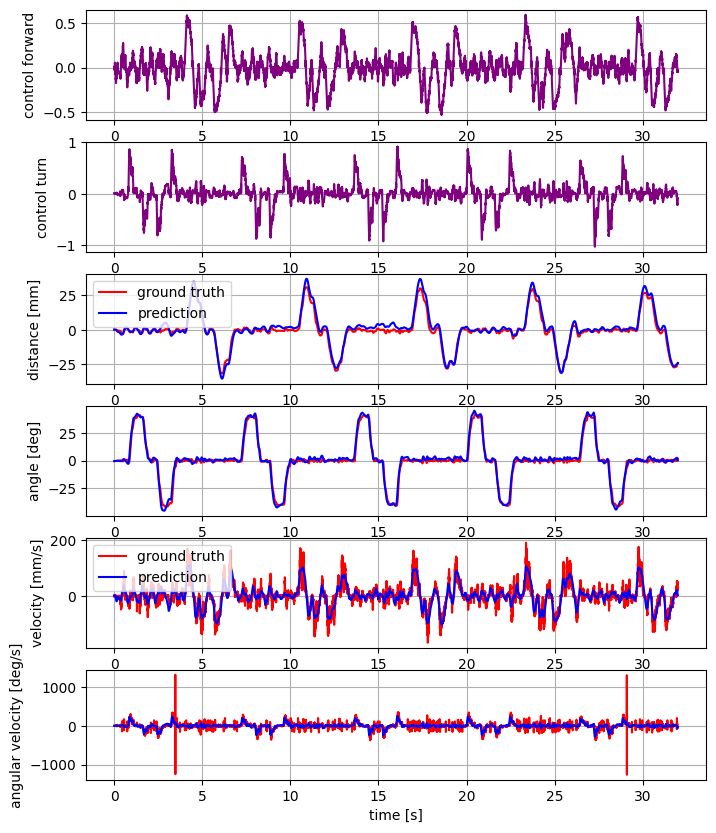

In [10]:
#model verification
#set same inputs and initial conditions



ds = LibsControl.DynamicalSystemDiscrete(a_est, b_est, c_est)    

x_initial = numpy.expand_dims(x_ref[0], axis=0).T
ds.reset(x_initial)

x_hat_result = []

for n in range(n_steps):

    u = u_result[n, :]
    u = numpy.expand_dims(u, axis=0).T

    x, y = ds.forward_state(u)

    x_hat_result.append(x[:, 0])

x_hat_result = numpy.array(x_hat_result)


#plot results
count = int(20*1.0/dt)
plot_results(t_result, u_result, x_ref, x_hat_result, 0)


In [11]:
#controller synthetis

#create loss weighting matrices (diagonal)
q = numpy.diag([ 1.0, 1.0, 0.0, 0.0] )
#r = numpy.diag( [10.0**6, 10.0])     
r = numpy.diag( [10.0**5, 10.0])     

        
prediction_horizon = 32 
control_horizon    = prediction_horizon//4 

#solve MPC controller 

#mpc = LibsControl.AnalyticalMPCBasic(a_est, b_est, q, r, prediction_horizon, control_horizon)
mpc = LibsControl.AnalyticalMPC(a_est, b_est, q, r, prediction_horizon, control_horizon)


(32, 4, 1)


<Figure size 640x480 with 0 Axes>

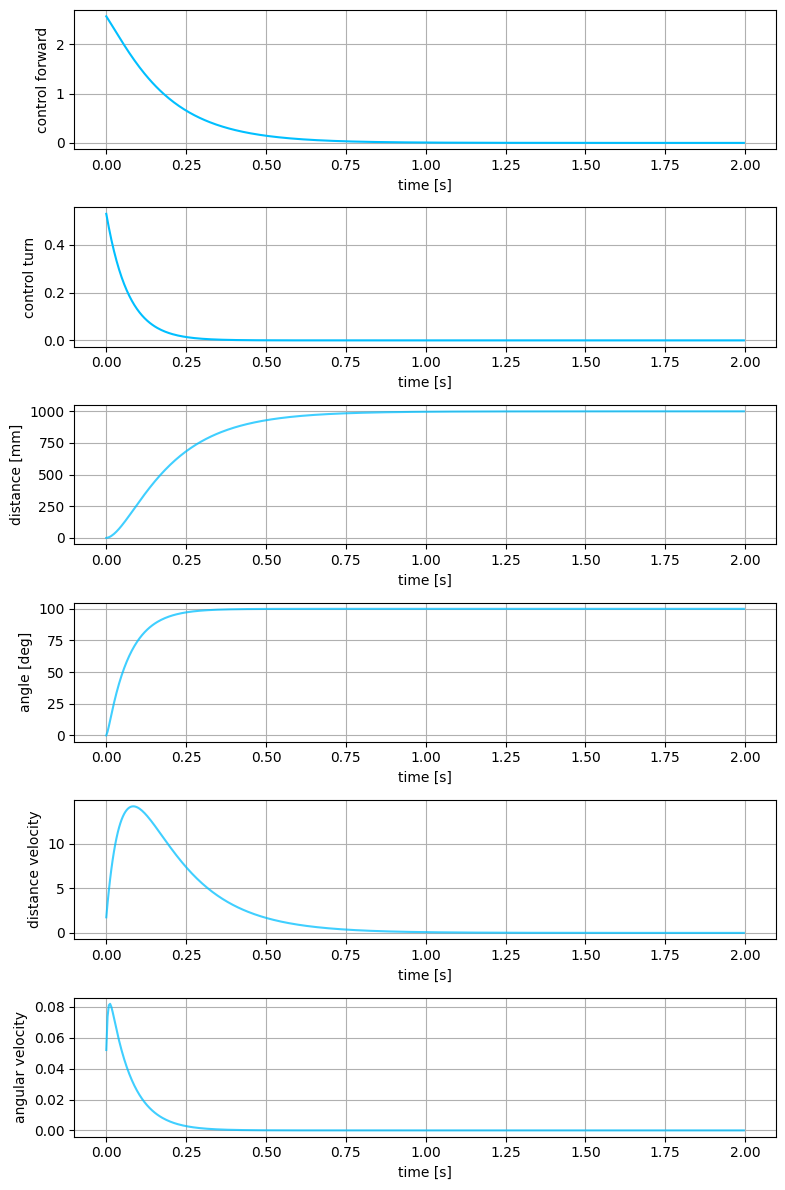

In [12]:
#process simulation

n_max = int(2.0/dt)

#required output, 1 meter, 100degrees
xr = numpy.array([[1000.0, 100.0*numpy.pi/180.0, 0.0, 0.0]]).T
#xr = numpy.array([[1000.0, 100.0*numpy.pi/180.0]]).T

#plant state
x = numpy.zeros((a_est.shape[0], 1))
u = numpy.zeros((b_est.shape[1], 1))

#result log
t_result = [] 
u_result = []   
x_result = []
int_result = []


xr_traj = []
for i in range(prediction_horizon):
    xr_traj.append(xr)

xr_traj = numpy.stack(xr_traj)

print(xr_traj.shape)

for n in range(n_max):

    #compute controller output
    u = mpc.forward(xr_traj, x, u)
    #u = mpc.forward(xr_traj, x)
    
    #compute plant output
    y = c_est@x
    x = a_est@x + b_est@u
    
    t_result.append(n*dt)
    u_result.append(u[:, 0].copy())
    x_result.append(x[:, 0].copy())

    
    
t_result = numpy.array(t_result)
u_result = numpy.array(u_result)

x_result = numpy.array(x_result)


du_result = x_result[1:, :] - x_result[0:-1, :]

#plot results
#convert angle to degrees
x_result[:, 1]*= 180.0/numpy.pi 

LibsControl.plot_closed_loop_response(t_result, u_result, x_result, x_hat = None, file_name = "lqr_controller_output.png", u_labels = ["control forward", "control turn"], x_labels = ["distance [mm]", "angle [deg]", "distance velocity", "angular velocity"])




<Figure size 640x480 with 0 Axes>

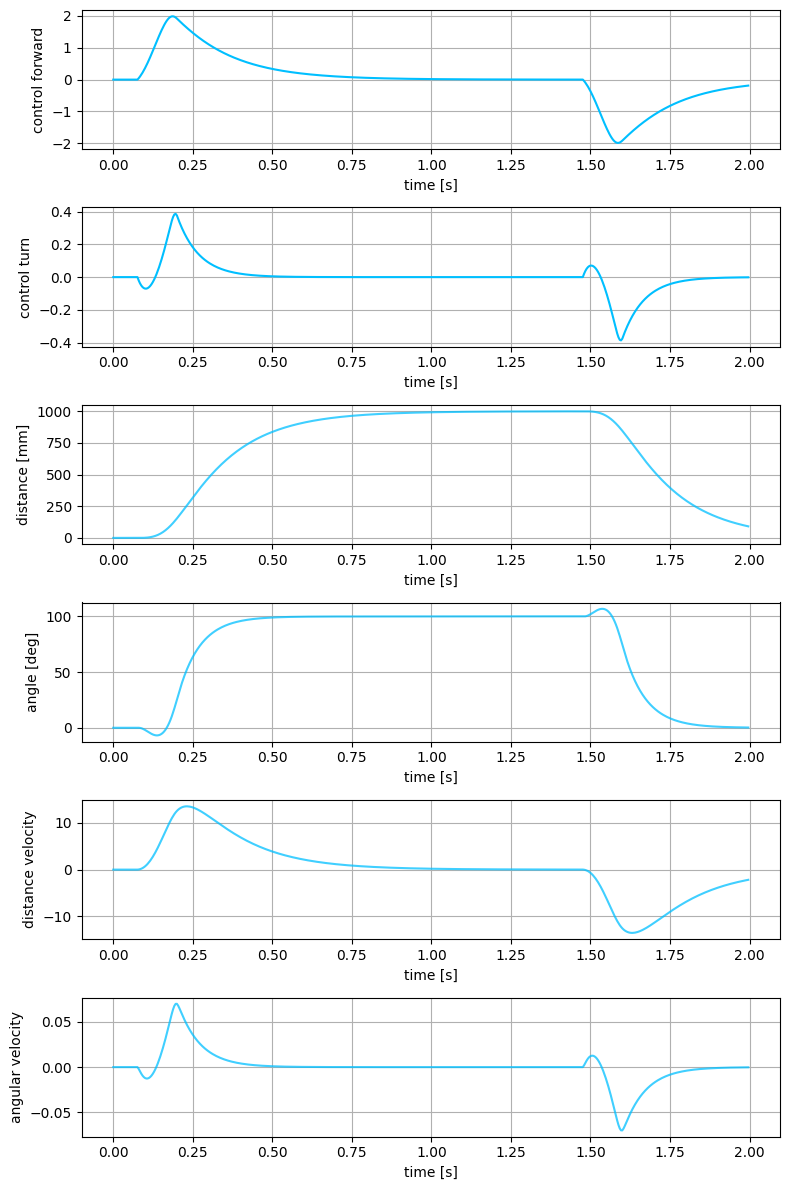

In [13]:
required_trajectory = numpy.zeros((n_max, 4))

# generate required trajectory
for n in range(n_max):
    if n > 0.8*n_max:
        required_trajectory[n, :] = 0.0
    elif n > 0.1*n_max:
        required_trajectory[n, 0] = 1000.0
        required_trajectory[n, 1] = 100.0*numpy.pi/180.0






#plant state
x = numpy.zeros((a_est.shape[0], 1))
u = numpy.zeros((b_est.shape[1], 1))

#result log
t_result = [] 
u_result = []   
x_result = []
int_result = []


for n in range(n_max):

    xr_traj = []
    for j in range(prediction_horizon):
        xr = required_trajectory[(n+j)%required_trajectory.shape[0]]
        xr = numpy.expand_dims(xr, 1)
        xr_traj.append(xr)

    xr_traj = numpy.stack(xr_traj)

    #compute controller output
    u = mpc.forward(xr_traj, x, u)
    #u = mpc.forward(xr_traj, x)
    
    #compute plant output
    y = c_est@x
    x = a_est@x + b_est@u
    
    t_result.append(n*dt)
    u_result.append(u[:, 0].copy())
    x_result.append(x[:, 0].copy())

    
    
t_result = numpy.array(t_result)
u_result = numpy.array(u_result)

x_result = numpy.array(x_result)


du_result = x_result[1:, :] - x_result[0:-1, :]

#plot results
#convert angle to degrees
x_result[:, 1]*= 180.0/numpy.pi 

LibsControl.plot_closed_loop_response(t_result, u_result, x_result, x_hat = None, file_name = "lqr_controller_output.png", u_labels = ["control forward", "control turn"], x_labels = ["distance [mm]", "angle [deg]", "distance velocity", "angular velocity"])



In [14]:
#print c-like arrays


phi_c   = matrix_to_c("phi", mpc.phi, const_array=True)
omega_c = matrix_to_c("omega", mpc.omega, const_array=True)
sigma_c = matrix_to_c("sigma", mpc.sigma, const_array=True)

result = "#ifndef _MPC_CONFIG_H_\n"
result+= "#define _MPC_CONFIG_H_\n"

result+= "\n\n\n"
result+= "#define MPC_SYSTEM_ORDER      ((uint32_t)" + str(a_est.shape[0]) + ")\n"
result+= "#define MPC_SYSTEM_INPUTS     ((uint32_t)" + str(b_est.shape[1]) + ")\n"
result+= "#define MPC_PREDCTION_HORIZON ((uint32_t)" + str(prediction_horizon) + ")\n"
result+= "#define MPC_CONTROL_HORIZON   ((uint32_t)" + str(control_horizon) + ")\n"
result+= "\n\n\n"

result+= phi_c + "\n\n"
result+= omega_c + "\n\n"
result+= sigma_c + "\n\n"

result+= "#endif\n"


f = open("mpc_config.h", "w")
f.write(result)
f.close()

print(result)


#ifndef _MPC_CONFIG_H_
#define _MPC_CONFIG_H_



#define MPC_SYSTEM_ORDER      ((uint32_t)4)
#define MPC_SYSTEM_INPUTS     ((uint32_t)2)
#define MPC_PREDCTION_HORIZON ((uint32_t)32)
#define MPC_CONTROL_HORIZON   ((uint32_t)8)



const float phi[] = {
		1.0, 0.0, 1.0, 0.0, 
		0.0, 1.0, 0.0, 1.0, 
		0.0, 0.0, 0.9189645, 0.0, 
		0.0, 0.0, 0.0, 0.47049063, 
		1.0, 0.0, 1.9189645, 0.0, 
		0.0, 1.0, 0.0, 1.4704907, 
		0.0, 0.0, 0.8444958, 0.0, 
		0.0, 0.0, 0.0, 0.22136144, 
		1.0, 0.0, 2.7634602, 0.0, 
		0.0, 1.0, 0.0, 1.6918521, 
		0.0, 0.0, 0.77606165, 0.0, 
		0.0, 0.0, 0.0, 0.10414849, 
		1.0, 0.0, 3.539522, 0.0, 
		0.0, 1.0, 0.0, 1.7960006, 
		0.0, 0.0, 0.7131731, 0.0, 
		0.0, 0.0, 0.0, 0.049000893, 
		1.0, 0.0, 4.252695, 0.0, 
		0.0, 1.0, 0.0, 1.8450015, 
		0.0, 0.0, 0.6553807, 0.0, 
		0.0, 0.0, 0.0, 0.023054462, 
		1.0, 0.0, 4.908076, 0.0, 
		0.0, 1.0, 0.0, 1.8680559, 
		0.0, 0.0, 0.6022717, 0.0, 
		0.0, 0.0, 0.0, 0.010846908, 
		1.0, 0.0, 5.5103474, 0.0, 
		0.0, 1.0, 0.0, 1.8789028, 
